In [36]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD

from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics
from avalanche.models import SimpleMLP
from avalanche.training.supervised import Naive
from avalanche.logging import InteractiveLogger

# Config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model
model = SimpleMLP(num_classes=10)

# CL Benchmark Creation
perm_mnist = PermutedMNIST(n_experiences=10)
train_stream = perm_mnist.train_stream
test_stream = perm_mnist.test_stream

# Prepare for training & testing
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, epoch_running=True, 
                     experience=True, stream=True),loggers=[InteractiveLogger()])

# Continual learning strategy
cl_strategy = Naive(
    model, optimizer, criterion, train_mb_size=32, train_epochs=2, 
    eval_mb_size=32, evaluator=eval_plugin, device=device)

# train and test loop
results = []
for train_task in train_stream:
    cl_strategy.train(train_task, num_workers=4)
    results.append(cl_strategy.eval(test_stream))

100%|██████████| 1875/1875 [00:11<00:00, 164.65it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8605
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9375
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.8605
100%|██████████| 1875/1875 [00:11<00:00, 168.11it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9242
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9375
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.9242
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 313/313 [00:01<00:00, 273.14it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9460
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 313/313 [00:01<00:00, 270.73it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task00

In [8]:
results

[{'Top1_Acc_MB/train_phase/train_stream/Task000': 0.9375,
  'Top1_RunningAcc_Epoch/train_phase/train_stream/Task000': 0.9249333333333334,
  'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.9249333333333334,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.9457,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001': 0.1037,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002': 0.133,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003': 0.0963,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004': 0.0892,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp005': 0.1314,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp006': 0.1031,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp007': 0.0866,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp008': 0.1101,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009': 0.1107,
  'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.19098},
 {'Top1_Acc_MB/train_phase/train_stream/Task000': 0.90625,
  'Top1_RunningAcc_Epoch/trai

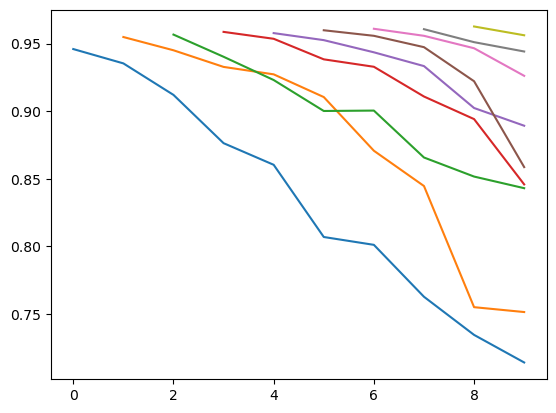

In [37]:
import matplotlib.pyplot as plt
tasks = [] # task idxs
accs = [] # average accuracy over currently trained tasks
ind_accs = [[] for t in results] # accuracies for each individual task over training
ind_iters = [[] for t in results]
# iterate over all training sessions
for i,exp in enumerate(results):
    # print(i+1," exps")
    tasks.append(i)
    avg = 0
    
    # for each session iterate over all currently trained tasks
    for idx in range(i+1):
        ind_accs[idx].append(exp['Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00'+str(idx)])
        ind_iters[idx].append(i)
        avg += exp['Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00'+str(idx)]
        # print(exp['Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00'+str(idx)])
    accs.append(avg/(i+1))

# plt.plot(tasks,accs)
for i,e in enumerate(ind_accs):
    plt.plot(ind_iters[i],e)